In [168]:
import torch
import torchvision
from pathlib import Path

In [3]:
import matplotlib.pyplot as plt
import torch
import torchvision
import torchinfo
from torch import nn
from torchvision import transforms

In [11]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device
     

'cuda'

In [12]:
data_path = Path("data2/")

In [13]:
image_path = data_path / "pizza_steak_sushi"
train_dir = image_path / "train"
test_dir = image_path / "test"

In [14]:
#Transforms
data_transform = transforms.Compose([
    transforms.Resize(size=(224,224)),
    # transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

In [15]:
from torchvision import datasets
train_data = datasets.ImageFolder(train_dir, transform=data_transform, target_transform=None)
test_data = datasets.ImageFolder(test_dir, transform=data_transform, target_transform=None)


In [16]:
from torch.utils.data import DataLoader
import os

In [17]:
train_dataloader = DataLoader(dataset=train_data, num_workers=os.cpu_count(), batch_size=32, shuffle=True)
test_dataloader = DataLoader(dataset=test_data, num_workers=os.cpu_count(), batch_size=32, shuffle=True)

In [18]:
#Patch Embeddings

In [140]:
class PatchEmbeddings(nn.Module):
    
    def __init__(self, 
                 in_channels: int=3, 
                 embeddings_dimensions: int=768,
                 patch_size: int=16):
        super().__init__()
        
        self.patch_size = patch_size
        self.patched_embeddings = nn.Conv2d(in_channels=in_channels, out_channels=embeddings_dimensions, stride=patch_size, padding=0, kernel_size=patch_size)
        
        self.flatten_embeddings = nn.Flatten(start_dim=2, end_dim=3)
        
    def forward(self, x):
        image_resolution = x.shape[-1]
        assert image_resolution % self.patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {self.patch_size}"

        x_patched = self.patched_embeddings(x)
        x_flatten = self.flatten_embeddings(x_patched)
        return x_flatten.permute(0,2,1)

In [102]:
class MultiHeadSelfAttentionBlock(nn.Module):
    
    def __init__(
        self,
        num_heads: int=12,
        embeddings_dimension: int=768,
        attn_dropout: int=0
    ):
        super().__init__()
        
        self.layer_norm = nn.LayerNorm(embeddings_dimension)
        self.multihead_attn_layer = nn.MultiheadAttention(embed_dim=embeddings_dimension, num_heads=num_heads, dropout=attn_dropout, batch_first=True)
        
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _  = self.multihead_attn_layer(query=x, key=x, value=x, need_weights=False)
        # print(attn_output)
        return attn_output
        
        

In [131]:
class MLPBlock(nn.Module):
  def __init__(self,
               embeddings_dimension:int=768,
               mlp_size:int=3072,
               dropout:int=0.1):
    super().__init__()
  

    self.layer_norm = nn.LayerNorm(normalized_shape=embeddings_dimension)


    self.mlp = nn.Sequential(
        nn.Linear(in_features=embeddings_dimension,
                  out_features=mlp_size),
        nn.GELU(),
        nn.Dropout(p=dropout),
        nn.Linear(in_features=mlp_size,
                  out_features=embeddings_dimension),
        nn.Dropout(p=dropout) 
    )
  
  def forward(self, x):
    x = self.layer_norm(x) 
    x = self.mlp(x)
    return x
    # return self.mlp(self.layer_norm(x)) # same as above 

In [132]:
class TransfornmerEncoderBlock(nn.Module):
    def __init__(
        self,
        num_heads: int=12,
        embeddings_dimension: int=768,
        dropout: int=0.1,
        mlp_size:  int=3072,
        attn_dropout: int=0
    ):
        super().__init__()
        
        self.msa_layer = MultiHeadSelfAttentionBlock(num_heads=num_heads, embeddings_dimension=embeddings_dimension, attn_dropout=attn_dropout)
        
        self.mlp_block = MLPBlock(dropout=dropout, embeddings_dimension=embeddings_dimension, mlp_size=mlp_size)
        
    def forward(self, x):
        x = self.msa_layer(x) + x
        x = self.mlp_block(x) + x
        
        return x

In [133]:
encoder = TransfornmerEncoderBlock()


In [134]:

torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, # embedding size from table 1
                                                             nhead=12, # heads from table 1
                                                             dim_feedforward=3072, # MLP size from table
                                                             dropout=0.1,
                                                             activation="gelu",
                                                             batch_first=True,
                                                             norm_first=True)

torch_transformer_encoder_layer

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
  (linear1): Linear(in_features=768, out_features=3072, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=3072, out_features=768, bias=True)
  (norm1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

In [135]:
from torchinfo import summary

summary(model=encoder,
        input_size=(1, 197, 768), # (batch_size, number_of_patches, embedding_d\imension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                 Input Shape          Output Shape         Param #              Trainable
TransfornmerEncoderBlock (TransfornmerEncoderBlock)     [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiHeadSelfAttentionBlock (msa_layer)               [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                           [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn_layer)        --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                                  [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                           [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                                 [1, 197, 768]        [1, 197, 768]        --                   True
│  

In [54]:
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768), # (batch_size, number_of_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])
     
     

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        7,087,872            True
Total params: 7,087,872
Trainable params: 7,087,872
Non-trainable params: 0
Total mult-adds (M): 0
Input size (MB): 0.61
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.61

In [150]:
class ViT(nn.Module):
    def __init__(
        self,
        num_heads: int=12,
        embeddings_dimension: int=768,
        dropout: int=0.1,
        mlp_size:  int=3072,
        attn_dropout: int=0,
        num_of_encoder_layers: int=12,
        patch_size: int=16,
        image_width: int=224,
        img_height: int=224,
        no_channels: int=3,
        classes: int=1000,
        positional_embedding_dropout: int=0.1
        
    ):
        assert (img_height * image_width) % patch_size == 0
        
        super().__init__()
        self.number_of_patches = (image_width * img_height)//(patch_size * patch_size)
        # print(self.number_of_patches
        self.patch_embeddings = PatchEmbeddings(in_channels=no_channels, embeddings_dimensions=embeddings_dimension,patch_size=patch_size)
        self.positional_embeddings = nn.Parameter(torch.randn(1, self.number_of_patches + 1, embeddings_dimension), requires_grad=True)
        self.cls_token = nn.Parameter(torch.randn(1,1, embeddings_dimension), requires_grad=True)
        
        # self.encoder_layer = TransfornmerEncoderBlock(num_heads=num_heads, embeddings_dimension=embeddings_dimension, dropout=dropout, mlp_size=mlp_size,attn_dropout=attn_dropout)
        
        self.encoder_block = nn.Sequential(*[TransfornmerEncoderBlock(num_heads=num_heads, embeddings_dimension=embeddings_dimension, dropout=dropout, mlp_size=mlp_size,attn_dropout=attn_dropout) for _ in range(num_of_encoder_layers)])
        
        self.classifier = nn.Sequential(
            
            nn.LayerNorm(embeddings_dimension),
            nn.Linear(in_features=embeddings_dimension, out_features=classes)
        )
        
        self.dropout_after_positional_embeddings = nn.Dropout(p=positional_embedding_dropout)
        
    def forward(self, x):
        batch_size = x.shape[0]
        x = self.patch_embeddings(x)
        prepend_token = self.cls_token.expand(batch_size, -1, -1) 
        
        x = torch.cat((prepend_token, x), dim=1)
        x = self.positional_embeddings + x
        x = self.dropout_after_positional_embeddings(x)
        x = self.encoder_block(x)
        x = self.classifier(x[:,0])
        
        return x
            
            
        

In [160]:
vit = ViT(classes=3)
vit

ViT(
  (patch_embeddings): PatchEmbeddings(
    (patched_embeddings): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (flatten_embeddings): Flatten(start_dim=2, end_dim=3)
  )
  (encoder_block): Sequential(
    (0): TransfornmerEncoderBlock(
      (msa_layer): MultiHeadSelfAttentionBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (multihead_attn_layer): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
        )
      )
      (mlp_block): MLPBlock(
        (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU(approximate='none')
          (2): Dropout(p=0.1, inplace=False)
          (3): Linear(in_features=3072, out_features=768, bias=True)
          (4): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (1): TransfornmerEncoderBl

In [161]:
summary(model=vit,
        input_size=(1, 3, 224, 224), # (batch_size, number_of_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])
     
     

Layer (type (var_name))                                           Input Shape          Output Shape         Param #              Trainable
ViT (ViT)                                                         [1, 3, 224, 224]     [1, 3]               152,064              True
├─PatchEmbeddings (patch_embeddings)                              [1, 3, 224, 224]     [1, 196, 768]        --                   True
│    └─Conv2d (patched_embeddings)                                [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
│    └─Flatten (flatten_embeddings)                               [1, 768, 14, 14]     [1, 768, 196]        --                   --
├─Dropout (dropout_after_positional_embeddings)                   [1, 197, 768]        [1, 197, 768]        --                   --
├─Sequential (encoder_block)                                      [1, 197, 768]        [1, 197, 768]        --                   True
│    └─TransfornmerEncoderBlock (0)                          

In [172]:

from going_modular.going_modular import engine

In [163]:
optimizer = torch.optim.Adam(weight_decay=0.03, params=vit.parameters(), lr=1e-3)
loss_fn = nn.CrossEntropyLoss()
device

'cuda'

In [165]:
results = engine.train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=10,
                       device=device)

 10%|█         | 1/10 [00:38<05:45, 38.40s/it]

Epoch: 1 | train_loss: 3.7493 | train_acc: 0.3906 | test_loss: 1.4861 | test_acc: 0.4223


 20%|██        | 2/10 [01:17<05:11, 38.88s/it]

Epoch: 2 | train_loss: 1.3639 | train_acc: 0.2930 | test_loss: 1.1930 | test_acc: 0.2576


 30%|███       | 3/10 [01:53<04:23, 37.60s/it]

Epoch: 3 | train_loss: 1.4697 | train_acc: 0.3203 | test_loss: 1.1419 | test_acc: 0.3400


 40%|████      | 4/10 [02:34<03:54, 39.00s/it]

Epoch: 4 | train_loss: 1.4833 | train_acc: 0.2812 | test_loss: 1.1800 | test_acc: 0.3627


 50%|█████     | 5/10 [03:18<03:23, 40.64s/it]

Epoch: 5 | train_loss: 1.4551 | train_acc: 0.3164 | test_loss: 1.1553 | test_acc: 0.3797


 60%|██████    | 6/10 [03:59<02:43, 40.81s/it]

Epoch: 6 | train_loss: 1.2083 | train_acc: 0.4102 | test_loss: 2.1599 | test_acc: 0.3598


 70%|███████   | 7/10 [04:36<01:59, 39.71s/it]

Epoch: 7 | train_loss: 1.4968 | train_acc: 0.4102 | test_loss: 2.2465 | test_acc: 0.3598


 80%|████████  | 8/10 [05:15<01:18, 39.21s/it]

Epoch: 8 | train_loss: 1.5548 | train_acc: 0.3828 | test_loss: 1.3088 | test_acc: 0.2576


 90%|█████████ | 9/10 [05:55<00:39, 39.56s/it]

Epoch: 9 | train_loss: 1.1478 | train_acc: 0.3281 | test_loss: 1.1941 | test_acc: 0.2803


100%|██████████| 10/10 [06:33<00:00, 39.37s/it]

Epoch: 10 | train_loss: 1.2055 | train_acc: 0.4102 | test_loss: 1.5209 | test_acc: 0.2973


In [166]:
from helper_functions import plot_loss_curves

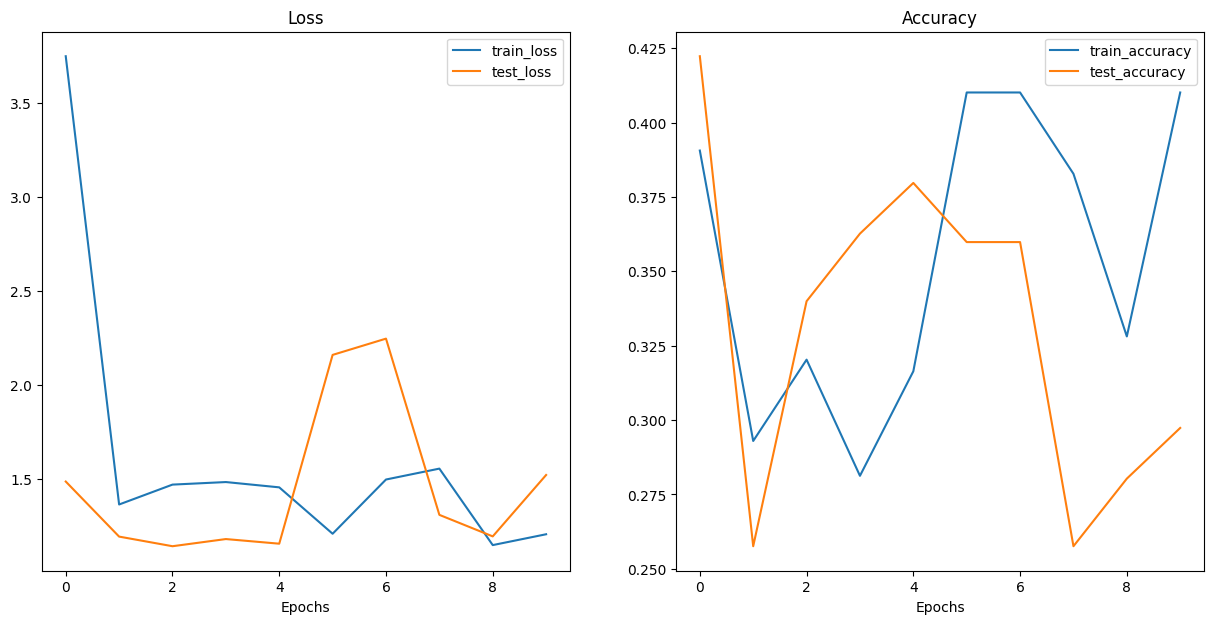

In [167]:
plot_loss_curves(results)